In [1]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer
from sklearn.metrics import auc, f1_score, roc_curve
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import cross_validate, cross_val_predict

%matplotlib inline

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')
# drive_path="drive/MyDrive/"

In [3]:
drive_path="/home/dezs/projects/myIDS/datasets/"

In [4]:
train=pd.read_csv(drive_path+"myDataset/train_clean.csv")
test=pd.read_csv(drive_path+"myDataset/test_clean.csv")

In [5]:
def multi_corr(col1, col2="label", df=train):
    '''
    This function returns correlation between 2 given features.
    Also gives corr of the given features with "label" afetr applying log1p to it.
    '''
    corr = df[[col1, col2]].corr().iloc[0,1]
    log_corr = df[col1].apply(np.log1p).corr(df[col2])

    print("Correlation : {}\nlog_Correlation: {}".format(corr, log_corr))

def corr(col1, col2="label", df=train):
    """
    This function returns correlation between 2 given features
    """
    return df[[col1, col2]].corr().iloc[0,1]

In [6]:
# Selecting all the features with high correlation values with other features
# Refer: https://chrisalbon.com/machine_learning/feature_selection/drop_highly_correlated_features/

train_prep = train.select_dtypes(exclude=['object'])

corr_matrix = train_prep.corr().abs()


In [7]:

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find index of feature columns with correlation greater than 0.9
to_drop = [column for column in upper.columns if any(upper[column] > 0.9)]

In [8]:
# We don't want to use these features for plotting because these are having high corr
# And most likely have same kind of plots with already plotted feature
print(to_drop)

['sloss', 'dloss', 'dpkts', 'dwin', 'ltime', 'synack', 'ackdat', 'ct_ftp_cmd']


In [9]:
#removed since it is label
# to_drop.remove('label')
# to_drop

In [10]:
print(len(to_drop))

8


In [11]:
import pickle

# Load the saved object
with open(drive_path+'myDataset/saved_infos.pkl', 'rb') as f:
    saved_infos = pickle.load(f)

# Now you can use the loaded_dict
print(saved_infos)
saved_infos['corr_col'] = to_drop

{'columns': ['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes', 'dbytes', 'sttl', 'dttl', 'sloss', 'dloss', 'service', 'sload', 'dload', 'spkts', 'dpkts', 'swin', 'dwin', 'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len', 'sjit', 'djit', 'stime', 'ltime', 'sintpkt', 'dintpkt', 'tcprtt', 'synack', 'ackdat', 'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login', 'ct_ftp_cmd', 'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm', 'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'label'], 'binary_col': ['is_sm_ips_ports', 'is_ftp_login'], 'corr_col': ['sloss', 'dloss', 'dpkts', 'dwin', 'ltime', 'synack', 'ackdat', 'ct_ftp_cmd'], 'to_drop': ['srcip', 'sport', 'dstip', 'dsport', 'label'], 'cat_col': ['proto', 'service', 'state'], 'num_col': ['dload', 'dbytes', 'ct_srv_src', 'ct_src_ltm', 'network_bytes', 'stcpb', 'tcprtt', 'djit', 'ct_dst_sport_ltm', 'dttl', 'sload', 'is_ftp_login', 'sjit', 'ct_src_dport_ltm', 'dur', 'ct_stat

In [12]:
train.drop(columns=to_drop, inplace=True)

In [13]:
train.shape

(1441591, 41)

In [14]:
train.columns

Index(['srcip', 'sport', 'dstip', 'dsport', 'proto', 'state', 'dur', 'sbytes',
       'dbytes', 'sttl', 'dttl', 'service', 'sload', 'dload', 'spkts', 'swin',
       'stcpb', 'dtcpb', 'smeansz', 'dmeansz', 'trans_depth', 'res_bdy_len',
       'sjit', 'djit', 'stime', 'sintpkt', 'dintpkt', 'tcprtt',
       'is_sm_ips_ports', 'ct_state_ttl', 'ct_flw_http_mthd', 'is_ftp_login',
       'ct_srv_src', 'ct_srv_dst', 'ct_dst_ltm', 'ct_src_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm', 'attack_cat',
       'label'],
      dtype='object')

In [15]:
train['network_bytes'] = train['sbytes'] + train['dbytes']

In [16]:
train.shape

(1441591, 42)

In [17]:
#drop IP columns, port and label since we are doing categorical classification
train.drop(['srcip', 'sport', 'dstip', 'dsport', 'label'], axis=1, inplace=True)

In [18]:
saved_infos['to_drop'] = ['srcip', 'sport', 'dstip', 'dsport', 'label']

In [19]:
x_train, y_train = train.drop(columns=['attack_cat']), train['attack_cat']
x_test, y_test = test.drop(columns=['attack_cat']), test['attack_cat']

In [20]:
print(x_train.shape, y_train.shape)
print(x_test.shape, y_test.shape)

(1441591, 36) (1441591,)
(617826, 48) (617826,)


In [21]:
mode_dict = train.mode().iloc[0].to_dict()

In [22]:
# # Saving all the files to disk to use later
# pickle.dump((x_train, y_train), open(drive_path+'myDataset/final_large_oversampled_train.pkl', 'wb'))
# pickle.dump((x_test, y_test), open(drive_path+'myDataset/final_test.pkl', 'wb'))

In [23]:
categorical_cols = x_train.select_dtypes(include=['object']).columns.tolist()
numerical_cols = x_train.select_dtypes(exclude=['object']).columns.tolist()

print("Categorical Columns:")
for col in categorical_cols:
    print(col)
print("\nNumerical Columns:")
for col in numerical_cols:
    print(col)

Categorical Columns:
proto
state
service

Numerical Columns:
dur
sbytes
dbytes
sttl
dttl
sload
dload
spkts
swin
stcpb
dtcpb
smeansz
dmeansz
trans_depth
res_bdy_len
sjit
djit
stime
sintpkt
dintpkt
tcprtt
is_sm_ips_ports
ct_state_ttl
ct_flw_http_mthd
is_ftp_login
ct_srv_src
ct_srv_dst
ct_dst_ltm
ct_src_ltm
ct_src_dport_ltm
ct_dst_sport_ltm
ct_dst_src_ltm
network_bytes


In [24]:
# getting categorical and numerical columns in 2 diff lists
cat_col = ['proto', 'service', 'state']
num_col = list(set(x_train.columns) - set(cat_col))

In [25]:
# To use later, during test data cleaning
saved_infos['cat_col'] = cat_col
saved_infos['num_col'] = num_col

In [26]:
scaler = StandardScaler()
scaler = scaler.fit(x_train[num_col])

In [27]:
x_train[num_col].head()

,sbytes,dttl,smeansz,network_bytes,is_sm_ips_ports,dur,ct_flw_http_mthd,ct_src_ltm,dmeansz,stime,...,res_bdy_len,spkts,sttl,stcpb,dload,dintpkt,ct_srv_src,dtcpb,sjit,swin
0,2934,29,56,6676,0,0.842647,0.0,2,69,1424227202,...,0,52,31,1407942856,3.487107e+04,15.888717,1,1408936820,1570.058531,255
1,3598,29,60,49634,0,0.043046,0.0,4,743,1421935380,...,0,60,31,3352695520,8.417785e+06,0.695869,4,3352969491,0.000000,255
2,146,29,73,324,0,0.000973,0.0,1,89,1421931152,...,0,2,31,0,7.317574e+05,0.004000,1,0,0.000000,0
3,1040,29,130,1864,0,0.003741,1.0,8,82,1421962992,...,83,8,31,2416355142,1.586742e+06,0.361556,2,2417282316,30.822092,255
4,1580,29,132,11748,0,1.005966,1.0,4,565,1421944600,...,3924,12,31,3074820599,7.637634e+04,59.141999,2,3075926884,9529.590799,255


In [28]:
x_train[num_col] = scaler.transform(x_train[num_col])

In [29]:
x_train[num_col].head()

,sbytes,dttl,smeansz,network_bytes,is_sm_ips_ports,dur,ct_flw_http_mthd,ct_src_ltm,dmeansz,stime,...,res_bdy_len,spkts,sttl,stcpb,dload,dintpkt,ct_srv_src,dtcpb,sjit,swin
0,-0.035545,-0.171563,-0.449314,-0.220349,-0.036481,0.014196,-0.236945,-0.602764,-0.769157,0.980729,...,-0.098957,0.167911,-0.24911,-0.071535,-0.651961,-0.040198,-0.849636,-0.070117,-0.006155,0.648648
1,-0.024502,-0.171563,-0.425003,0.014240,-0.036481,-0.047135,-0.236945,-0.046095,1.214775,-1.019176,...,-0.098957,0.268431,-0.24911,1.287459,1.219132,-0.052027,-0.270688,1.289097,-0.120261,0.648648
2,-0.081912,-0.171563,-0.345991,-0.255037,-0.036481,-0.050363,-0.236945,-0.881099,-0.710287,-1.022865,...,-0.098957,-0.460342,-0.24911,-1.055405,-0.496414,-0.052565,-0.849636,-1.055207,-0.120261,-1.541695
3,-0.067044,-0.171563,0.000448,-0.246627,-0.036481,-0.050150,1.752027,1.067243,-0.730891,-0.995081,...,-0.097365,-0.384952,-0.24911,0.633144,-0.305579,-0.052287,-0.656654,0.634890,-0.118021,0.648648
4,-0.058063,-0.171563,0.012604,-0.192652,-0.036481,0.026724,1.752027,-0.046095,0.690829,-1.011130,...,-0.023656,-0.334691,-0.24911,1.093280,-0.642697,-0.006524,-0.656654,1.095397,0.572315,0.648648


In [30]:
service_ = OneHotEncoder()
proto_ = OneHotEncoder()
state_ = OneHotEncoder()
ohe_service = service_.fit(x_train.service.values.reshape(-1,1))
ohe_proto = proto_.fit(x_train.proto.values.reshape(-1,1))
ohe_state = state_.fit(x_train.state.values.reshape(-1,1))

In [31]:
x_train.shape

(1441591, 36)

In [32]:
for col, ohe in zip(['proto', 'service', 'state'], [ohe_proto, ohe_service, ohe_state]):
    x = ohe.transform(x_train[col].values.reshape(-1,1))
    tmp_df = pd.DataFrame(x.todense(), columns=[col+'_'+str(i) for i in ohe.categories_[0]])
    x_train = pd.concat([x_train.drop(col, axis=1), tmp_df], axis=1)

In [33]:
train=pd.concat([x_train, y_train], axis=1)
train = train.rename(columns={0: 'attack_cat'})

In [34]:
train.head()

,dur,sbytes,dbytes,sttl,dttl,sload,dload,spkts,swin,stcpb,...,state_MAS,state_PAR,state_REQ,state_RST,state_TST,state_TXD,state_URH,state_URN,state_no,attack_cat
0,0.014196,-0.035545,-0.224295,-0.24911,-0.171563,-0.123259,-0.651961,0.167911,0.648648,-0.071535,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
1,-0.047135,-0.024502,0.023953,-0.24911,-0.171563,-0.114635,1.219132,0.268431,0.648648,1.287459,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
2,-0.050363,-0.081912,-0.245214,-0.24911,-0.171563,-0.115422,-0.496414,-0.460342,-1.541695,-1.055405,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
3,-0.050150,-0.067044,-0.241422,-0.24911,-0.171563,-0.097009,-0.305579,-0.384952,0.648648,0.633144,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal
4,0.026724,-0.058063,-0.186577,-0.24911,-0.171563,-0.123476,-0.642697,-0.334691,0.648648,1.093280,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,normal


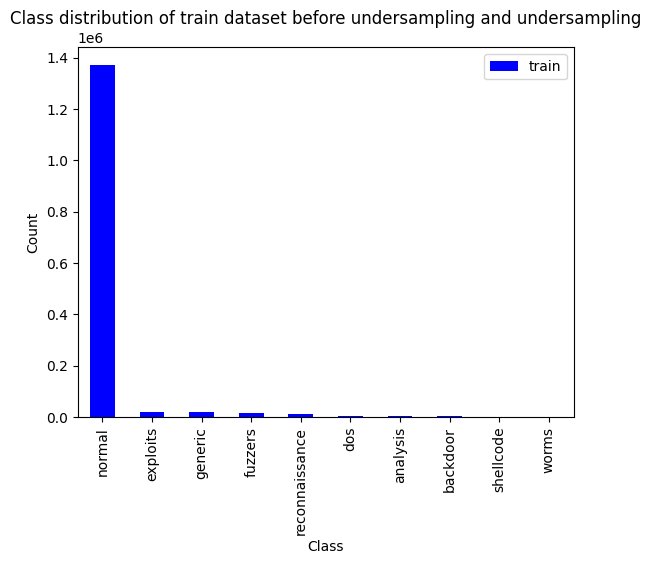

In [35]:
plt.figure()
plt.title("Class distribution of train dataset before undersampling and undersampling")
train['attack_cat'].value_counts().plot(kind="bar", color='b', label="train")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [36]:
train['attack_cat'].value_counts()

attack_cat
normal            1371997
exploits            19447
generic             17691
fuzzers             15175
reconnaissance       9297
dos                  3970
analysis             1488
backdoor             1374
shellcode            1039
worms                 113
Name: count, dtype: int64

In [37]:
attack_cat=train['attack_cat'].unique().tolist()
attack_cat

['normal',
 'exploits',
 'generic',
 'dos',
 'reconnaissance',
 'fuzzers',
 'analysis',
 'backdoor',
 'worms',
 'shellcode']

In [38]:
from sklearn.utils import resample
def random_undersample(df,n_sample,random_state):
    df_undersampled = resample(df, 
                            replace=False,
                            n_samples=n_sample,
                            random_state=random_state)
    return df_undersampled


def random_oversample(df,n_sample,random_state):
    df_oversampled = resample(df, 
                            replace=True,
                            n_samples=n_sample,
                            random_state=random_state)
    return df_oversampled

In [39]:
train["attack_cat"].value_counts()

attack_cat
normal            1371997
exploits            19447
generic             17691
fuzzers             15175
reconnaissance       9297
dos                  3970
analysis             1488
backdoor             1374
shellcode            1039
worms                 113
Name: count, dtype: int64

In [40]:
target_datapoint_count=2000000 #200000 for each category

In [41]:
value_counts = train['attack_cat'].value_counts()
new_dataset=pd.DataFrame()

target_count_per_category=int(target_datapoint_count/10)

for label, count in value_counts[value_counts > target_count_per_category].items():
    df_undersampled=random_undersample(train[train['attack_cat'] == label], target_count_per_category,3)
    new_dataset = pd.concat([new_dataset, df_undersampled])

for label, count in value_counts[value_counts <= target_count_per_category].items():
    df_oversampled=random_oversample(train[train['attack_cat'] == label], target_count_per_category,3)
    new_dataset = pd.concat([new_dataset, df_oversampled])

In [42]:
new_dataset["attack_cat"].value_counts()

attack_cat
normal            200000
exploits          200000
generic           200000
fuzzers           200000
reconnaissance    200000
dos               200000
analysis          200000
backdoor          200000
shellcode         200000
worms             200000
Name: count, dtype: int64

In [43]:
train=new_dataset

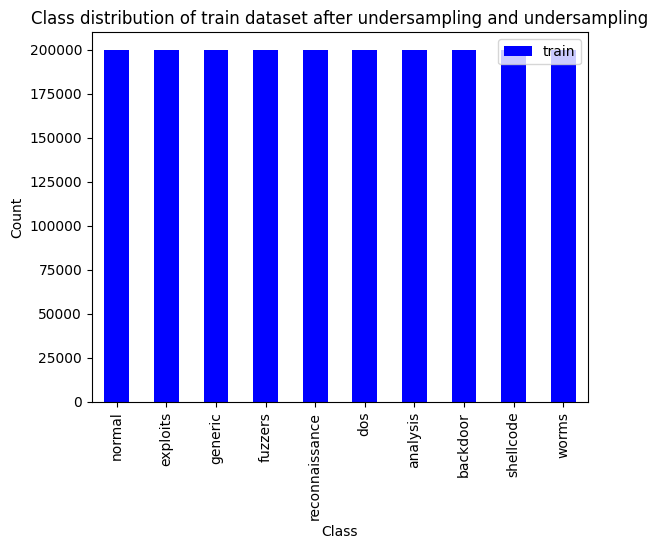

In [44]:
plt.figure()
plt.title("Class distribution of train dataset after undersampling and undersampling")
train['attack_cat'].value_counts().plot(kind="bar", color='b', label="train")
plt.xlabel("Class")
plt.ylabel("Count")
plt.legend()
plt.show()

In [45]:
train=train.reset_index(drop=True)

In [46]:
x_train, y_train = train.drop(columns=['attack_cat']), train['attack_cat']

In [47]:
from sklearn import preprocessing

label_encoder = preprocessing.LabelEncoder()
y_train= label_encoder.fit_transform(y_train)
y_train=  pd.Series(y_train)

In [48]:
y_train.value_counts()

6    200000
3    200000
5    200000
4    200000
7    200000
2    200000
0    200000
1    200000
8    200000
9    200000
Name: count, dtype: int64

In [49]:
file_path = drive_path+'myDataset/'

In [50]:
# pickle.dump(scaler, open(file_path+'scaler.pkl', 'wb'))  # Standard scaler
# pickle.dump(saved_infos, open(file_path+'saved_infos.pkl', 'wb'))  # Dictionary with important parameters
# pickle.dump(mode_dict, open(file_path+'mode_dict.pkl', 'wb'))  #  Dictionary with most frequent values of columns

In [51]:
# # Onehot encoder for categorical columns
# pickle.dump(ohe_proto, open(file_path+'ohe_proto.pkl', 'wb'))
# pickle.dump(ohe_service, open(file_path+'ohe_service.pkl', 'wb'))
# pickle.dump(ohe_state, open(file_path+'ohe_state.pkl', 'wb'))

# #save the label encoder
# pickle.dump(label_encoder, open(file_path+'label_encoder.pkl', 'wb'))

In [52]:
# # Cleaned and processed train data
# pickle.dump((x_train, y_train), open(file_path+'final_large_oversampled_train.pkl', 'wb'))